<a href="https://colab.research.google.com/github/jocelynandrade18/Repositorio2.-/blob/main/Modelo_del_Protot%C3%ADpico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MODELO MLP PARA CLASIFICAR CANDIDATOS DOCENTES UNRC**

**Importar librerías**

In [38]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

**Carga y limpieza de Datos**

In [48]:
file = "Base de datos para el PP (actualizada).xlsx"
df = pd.read_excel(file, header=1)

# Limpiar los nombres de las columnas para que coincidan con las características esperadas
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

print("Columnas encontradas (limpias):")
print(df.columns)

# Normalizar nombres de columna (quitar espacios y minúsculas para evitar errores)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("á","a").str.replace("é","e").str.replace("í","i").str.replace("ó","o").str.replace("ú","u")

print("Columnas disponibles:")
print(df.columns.tolist())

Columnas encontradas (limpias):
Index(['Unnamed:_0', 'ID', 'Nombre', 'Apellidos', 'Edad', 'Procedencia',
       'Entidad_Federativa', 'Zona_Geográfica', 'Nivel_Educativo',
       'Campo_Estudio', 'Tipo_Institución', 'Institución', 'Rango_Ingreso',
       'Experiencia_años', 'Jornada', 'Nivel'],
      dtype='object')
Columnas disponibles:
['Unnamed:_0', 'ID', 'Nombre', 'Apellidos', 'Edad', 'Procedencia', 'Entidad_Federativa', 'Zona_Geografica', 'Nivel_Educativo', 'Campo_Estudio', 'Tipo_Institucion', 'Institucion', 'Rango_Ingreso', 'Experiencia_años', 'Jornada', 'Nivel']


**Seleccionar variables PARA EL MODELO**

In [49]:
# Nombres esperados (ajustados a la normalización anterior)
expected_features = ["Experiencia_años", "Nivel_Educativo", "Campo_Estudio"]

# Aplica la misma normalizacion a los nombres esperados para comparación robusta
expected_features_norm = [c.strip().replace(" ", "_").replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u") for c in expected_features]
target_col = "Nivel"
target_col_norm = target_col.strip().replace(" ", "_")

# Verificar existencia de columnas
missing = [c for c in expected_features_norm + [target_col_norm] if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el Excel: {missing}. Revisa los nombres exactos de columna (imprimí arriba).")

# Usar columnas normalizadas
features = expected_features_norm
target = target_col_norm

df = df[features + [target]].copy()

**Preprocesar columnas**

In [53]:
df["Experiencia_años"] = pd.to_numeric(df["Experiencia_años"], errors='coerce')

# Categorías a texto seguro
df["Nivel_Educativo"] = df["Nivel_Educativo"].fillna("Desconocido").astype(str)
df["Campo_Estudio"] = df["Campo_Estudio"].fillna("Desconocido").astype(str)

df[target] = df[target].astype(str)

# Eliminar filas con datos faltantes
df = df.dropna(subset=["Experiencia_años", "Nivel_Educativo", "Campo_Estudio", target])

**Variables categorías**

In [58]:
df_cat = pd.get_dummies(
    df[["Nivel_Educativo", "Campo_Estudio"]],
    prefix=["NivelEd", "Campo"]
)

# Dataset final de entrada X
X_df = pd.concat(
    [df[["Experiencia_años"]].reset_index(drop=True),
     df_cat.reset_index(drop=True)],
    axis=1
)

X = X_df.values

# Codificación del target
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df[target])
y = to_categorical(y_encoded)

print("Información del preprocesamiento")
print("Shape de X:", X.shape)
print("Clases del target:", encoder.classes_)
print("Columnas finales en X:", X_df.columns.tolist())

Información del preprocesamiento
Shape de X: (300, 35)
Clases del target: ['A' 'B' 'C']
Columnas finales en X: ['Experiencia_años', 'NivelEd_Doctorado', 'NivelEd_Licenciatura', 'NivelEd_Maestría', 'NivelEd_Posdoctorado', 'Campo_Administración', 'Campo_Arquitectura', 'Campo_Carpintería', 'Campo_Ciencias', 'Campo_Ciencias Ambientales', 'Campo_Ciencias Sociale', 'Campo_Ciencias Sociales', 'Campo_Computación', 'Campo_Comunicación', 'Campo_Contaduría', 'Campo_Derecho', 'Campo_Diseño', 'Campo_Educación', 'Campo_Electricidad', 'Campo_Enfermería', 'Campo_Finanzas', 'Campo_Informática', 'Campo_Ingeniería', 'Campo_Investigación', 'Campo_Laboratorio', 'Campo_Mecánica', 'Campo_Medicina', 'Campo_Negocios', 'Campo_Pedagogía', 'Campo_Psicología', 'Campo_Radiología', 'Campo_Salud', 'Campo_Tecnología', 'Campo_Tecnologías de la Información', 'Campo_Turismo']


**División 80% entrenamiento / 20% prueba**

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

**Escalar datos**

In [60]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Construcción del modelo MLP**

In [61]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,963 (19.39 KB)

 Trainable params: 4,963 (19.39 KB)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento del Modelo**

In [62]:
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3932 - loss: 1.0371 - val_accuracy: 0.5000 - val_loss: 1.0335
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6004 - loss: 0.8624 - val_accuracy: 0.7000 - val_loss: 0.9306
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7989 - loss: 0.7099 - val_accuracy: 0.8167 - val_loss: 0.8267
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8297 - loss: 0.6060 - val_accuracy: 0.8500 - val_loss: 0.7088
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9121 - loss: 0.4956 - val_accuracy: 0.8667 - val_loss: 0.5741
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9849 - loss: 0.3032 - val_accuracy: 0.8667 - val_loss: 0.4759
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9560 - loss: 0.2323 - val_accuracy: 0.8833 - val_loss: 0.3715
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9580 - loss: 0.1211 - val_accuracy: 0.8833 - val_loss

**Evaluación Final**

In [63]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nAccuracy en conjunto de prueba: {acc:.4f}")
print(f"Pérdida (loss): {loss:.4f}")


Accuracy en conjunto de prueba: 0.9833
Pérdida (loss): 0.0228


**Gráfica de función de pérdida**

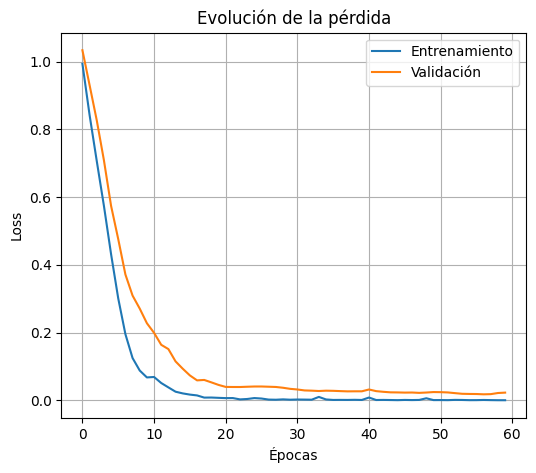

In [64]:
plt.figure(figsize=(6,5))
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolución de la pérdida")
plt.grid()
plt.legend()
plt.show()

**Matriz de confusión**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


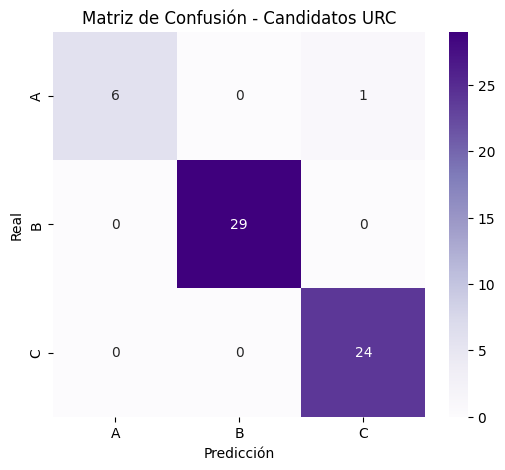

In [69]:
y_pred_prob = model.predict(X_test)
y_pred_idx = np.argmax(y_pred_prob, axis=1)
y_true_idx = np.argmax(y_test, axis=1)

y_pred_labels = encoder.inverse_transform(y_pred_idx)
y_true_labels = encoder.inverse_transform(y_true_idx)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Candidatos URC")
plt.show()

**Ejemplo de Predicción**

In [68]:
ejemplo = np.array([[5, "Maestria", "Ciencias Sociales"]], dtype=object)

# Convertir ejemplo a dataframe para aplicar dummies igual que al dataset
ejemplo_df = pd.DataFrame(ejemplo, columns=["Experiencia_años", "Nivel_Educativo", "Campo_Estudio"])

ejemplo_df["Experiencia_años"] = pd.to_numeric(ejemplo_df["Experiencia_años"], errors='coerce')

ejemplo_dum = pd.get_dummies(
    ejemplo_df[["Nivel_Educativo", "Campo_Estudio"]],
    prefix=["NivelEd", "Campo"]
)

# Alinear columnas del ejemplo con las de X_df
ejemplo_aligned = ejemplo_dum.reindex(columns=X_df.columns[1:], fill_value=0)

ejemplo_final = np.concatenate([ejemplo_df[["Experiencia_años"]].values,
                                ejemplo_aligned.values], axis=1)

ejemplo_scaled = scaler.transform(ejemplo_final)

pred = model.predict(ejemplo_scaled)
idx = np.argmax(pred)
clase = encoder.inverse_transform([idx])[0]

print("\n=== EJEMPLO DE PREDICCIÓN ===")
print("Nivel predicho:", clase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step

=== EJEMPLO DE PREDICCIÓN ===
Nivel predicho: C
